January 2019

## General Practice Prescribing Analysis

### Introduction
This is an analysis of prescribing in general practice across England for the month of April 2018 that I carried out as part of my Masters in Health Data Science at UCL.   Datasets are freely available from NHS Digital 
<a href='https://digital.nhs.uk/data-and-information/publications/statistical/practice-level-prescribing-data/april-2018'>here</a> and <a href='https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice/patients-registered-at-a-gp-practice-april-2018-special-topic---registered-patients-compared-to-the-projected-resident-population-in-england'>here.</a>
There are three principle databases of interest:
<ul>
    <li>Registrations database: Details the number of patients registered at each GP practice (identified by a a practice code)</li>
    <li>Practice database: Details the practice name and address for each practice code</li>
    <li>Prescribing database: This is a very large file (1.4 GB) which contains information on all medicines, dressings and appliances prescribed by all practices.</li>
    <li>Pharmacy database: Links nine character stems of BNF codes to the drug name</li>
</ul>
<p>The prescription processing activity is internally audited to 97.5% accuracy (meaning at least 97.5% of prescriptions are recorded accurately)</p>
<p>I will be using Pandas and other standard modules to analysis the data.</p>

In [2]:
#preliminaries
import pandas as pd
import re
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plot
%matplotlib inline

In [3]:
# Import data sets
local_path = "/Users/tom/Documents/datasci/DMHR/Assignment/"

registration_file = 'gp-reg-pat-prac-all.csv'
practice_file = 'T201804ADDR+BNFT.CSV'
prescribing_file = 'T201804PDPI+BNFT.CSV'
pharm_file = 'T201804CHEM+SUBS.CSV'

reg_url = 'https://files.digital.nhs.uk/71/B59D99/'
pract_url = 'https://files.digital.nhs.uk/20/09E30B/'
presc_url = 'https://files.digital.nhs.uk/38/03EC1C/'
pharm_url = 'https://files.digital.nhs.uk/79/6D58A8/'

prescribing_cols = ['sha', 'pct', 'practice_code', 'bnf_code', 'bnf_name', 'items', 'nic', 'act_cost', \
                    'quantity', 'period']
practice_cols = ['time_period', 'practice_code', 'practice_name', 'practice_organization', 'street', 'city', 
    'area', 'postcode']
pharm_cols = ['chem_sub','name','drop1','drop2']

# To load locally saved files, they should be saved in path set with 'local_path' and with the default file names
try:
    registrations_df = pd.read_csv(local_path+registration_file, index_col= False)
    practice_df = pd.read_csv(local_path+practice_file, header=None, names=practice_cols, index_col=False)
    prescribing_df = pd.read_csv(local_path+prescribing_file, names=prescribing_cols, skiprows=1, index_col= False)
    pharm_df = pd.read_csv(local_path+pharm_file, skiprows=1, names=pharm_cols, index_col=False)

    
except FileNotFoundError:
    registrations_df = pd.read_csv(reg_url+registration_file, index_col= False)
    practice_df =      pd.read_csv(pract_url+practice_file, header=None, names=practice_cols, index_col=False)
    prescribing_df =   pd.read_csv(presc_url+prescribing_file, names=prescribing_cols, skiprows=1, index_col= False)
    pharm_df = pd.read_csv(phrm_url+pharm_file, skiprows=1, names=pharm_cols, index_col=False)

After importing the databases, they require some reformatting.  Column names are standardized and white space around the textual data is stripped.

In [4]:
#rename columns with lower case indexes.  rename code to practice_code
registrations_df.columns = registrations_df.columns.str.lower()
registrations_df.rename(columns={'code':'practice_code'},inplace = True)

print("Before processing, data appears as:'"+practice_df['city'][50]+"'" )

Before processing, data appears as:'HARTLEPOOL               '


In [5]:
# Strip white space from data in all columns of type object (ie strings)
for column in prescribing_df.columns:
    if prescribing_df[column].dtype == 'object':
        prescribing_df[column] = prescribing_df[column].str.strip()
for column in practice_df.columns:
    if practice_df[column].dtype == 'object':
        practice_df[column] = practice_df[column].str.strip()
        if practice_df[column].name == 'postcode':
            practice_df[column] = practice_df[column].str.upper()
        else:
            practice_df[column] = practice_df[column].str.title()
print("After processing, data appears as:'"+practice_df['city'][50]+"'" )

pharm_df.columns = ['chem_sub','name','drop1','drop2']
pharm_df = pharm_df.drop(['drop1','drop2'], axis=1)
pharm_df.name = pharm_df.name.str.strip(' .')

After processing, data appears as:'Hartlepool'


The databases now look like this:

In [6]:
registrations_df.head()

,publication,extract_date,type,ccg_code,ons_ccg_code,practice_code,postcode,sex,age,number_of_patients
0,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83005,DL1 3RT,ALL,ALL,11826
1,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83006,DL3 6HZ,ALL,ALL,8044
2,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83010,DL3 9JP,ALL,ALL,14070
3,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83013,DL1 4YL,ALL,ALL,11298
4,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83031,DL3 8SQ,ALL,ALL,10109


In [7]:
practice_df.head()

,time_period,practice_code,practice_name,practice_organization,street,city,area,postcode
0,201804,A81001,The Densham Surgery,The Health Centre,Lawson Street,Stockton-On-Tees,Cleveland,TS18 1HU
1,201804,A81002,Queens Park Medical Centre,Queens Park Medical Ctr,Farrer Street,Stockton On Tees,Cleveland,TS18 2AW
2,201804,A81004,Bluebell Medical Centre,Trimdon Avenue,Acklam,Middlesbrough,,TS5 8SB
3,201804,A81005,Springwood Surgery,Springwood Surgery,Rectory Lane,Guisborough,,TS14 7DJ
4,201804,A81006,Tennant Street Medical Practice,Tennant St Medical Pract,Tennant Street,Stockton-On-Tees,Cleveland,TS18 2AT


In [8]:
prescribing_df.head()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,period
0,Q44,RTV,Y04937,0401010Z0AAAAAA,Zopiclone_Tab 7.5mg,6,1.56,2.12,63,201804
1,Q44,RTV,Y04937,0401020K0AAAHAH,Diazepam_Tab 2mg,4,0.87,1.15,73,201804
2,Q44,RTV,Y04937,0401020K0AAAIAI,Diazepam_Tab 5mg,2,0.46,0.56,35,201804
3,Q44,RTV,Y04937,0402010ABAAABAB,Quetiapine_Tab 25mg,1,2.60,2.52,14,201804
4,Q44,RTV,Y04937,0402010ADAAAAAA,Aripiprazole_Tab 10mg,1,1.53,1.53,14,201804


These column names refer to the following fields:
- sha: code of the Strategic Health Authority in which the practice resides
- pct: code of the Primary Care Trust in which the practice resides
- practice code:  this is the GP practice code which can be used to linked to other data
- bnf_code: BNF code for each drug (characters 1 and 2 show the BNF chapter,3 and 4 show the BNF section)
- bnf_name:  individual preparation name, which may be proprietary or generic, followed by form and strength
- items: the number of items for this presentation that were dispensed in April. ie number of prescriptions
- nic: Net ingredient cost. This is the basic cost of a drug (list price excluding VAT)
- act_cost: the actual cost charged back to practices from all dispensed prescriptions
- quantity: The quantity of a drug dispensed for all prescriptions (measured in units depending on the formulation of the product: a number for tablets, capsules, ampoules, vials etc; millilitres for liquids; grams for solids (such as cream, gel, ointment))
- period: This period is April 2018

In [9]:
pharm_df.head()

,chem_sub,name
0,0101010A0,Alexitol Sodium
1,0101010B0,Almasilate
2,0101010C0,Aluminium Hydroxide
3,0101010D0,Aluminium Hydroxide With Magnesium
4,0101010E0,Hydrotalcite


## Missing values

In [10]:
practice_df[practice_df=='']=np.nan
practice_df.isnull().sum()

time_period                 0
practice_code               0
practice_name               0
practice_organization       4
street                    688
city                      363
area                     1918
postcode                    0
dtype: int64

The practice database (containing address information)  has missing data in four columns.  Inspecting this below revelas that there are inconsistencies with how address information is stored.  For example, 'city' may be stored in the 'city' column, but it could also appear in the 'street' column, or 'area' column.  There are no missing values for postcode (including postcodes starting with 'Z' which could be used to indicate 'missingness'.

In [11]:
practice_df[practice_df.city.isnull() & practice_df.area.isnull()]

,time_period,practice_code,practice_name,practice_organization,street,city,area,postcode
6878,201804,N83638,St Helens Nhs Wic,Bickerstaffe Street,St Helens,NaN,NaN,WA10 1DH
6899,201804,C87621,Broom Valley Road Surgery,102-104 Broom Valley Road,Rotherham,NaN,NaN,S60 2QY
7029,201804,Y00175,Soho Walk In Centre (Wic),1 Frith Street,London,NaN,NaN,W1D 3QS
7050,201804,Y00233,The Parallel,9A Churchgate,Bolton,NaN,NaN,BL1 1HU
7062,201804,Y00280,Belgrave Surgery (Sv Bapodra),13 Loughborough Road,Leicester,NaN,NaN,LE4 5LJ
7476,201804,Y02158,Gpsi Dermatology Heavitree Hc,The Heavitree Practice,Heavitree Hc Sth Lawn Tce,NaN,NaN,EX1 2RX
8845,201804,Y04975,Oadby Urgent Care Centre (Nduc) Ooh,Oadby Ucc,The Parade Oadby,NaN,NaN,LE2 5BJ
9051,201804,Y05281,Whants Comm Ent,Unit 10.1.1 Leathermarket,11-13 Weston Street,NaN,NaN,SE1 3ER
9186,201804,Y05473,T & G Adult Adhd Service,Outram Rd,Dukinfield,NaN,NaN,SK16 4XE


In [12]:
practice_df[practice_df.city.isnull() & practice_df.street.isnull()].head()

,time_period,practice_code,practice_name,practice_organization,street,city,area,postcode
1936,201804,E84015,Willow Tree Family Doctors,343B Stag Lane,NaN,NaN,London,NW9 9AD
1973,201804,E84076,Oxgate Gardens Surgery,81 Oxgate Gardens,NaN,NaN,London,NW2 6EA
2169,201804,E87007,Westbourne Grove Medical Centre,241 Westbourne Grove,NaN,NaN,London,W11 2SE
2174,201804,E87013,Stanhope Mews Surgery,7 Stanhope Mews West,NaN,NaN,London,SW7 5RB
2176,201804,E87021,Shirland Road Medical Centre,321 Shirland Road,NaN,NaN,London,W9 3JJ


In [13]:
#Count instances with data missing from street, city and area
practice_df[practice_df.street.isnull() & practice_df.area.isnull()& practice_df.city.isnull()].shape[0]

0

In [14]:
#Count postcodes starting with 'Z' - may indicate missing values
practice_df[practice_df.postcode.str.startswith('Z')].shape[0]

0

In [15]:
registrations_df[registrations_df=='']=np.nan
prescribing_df[prescribing_df=='']=np.nan
missing_values = registrations_df.isnull().sum().sum() + prescribing_df.isnull().sum().sum()
print('There are %s missing values in the registations and prescribing databases'%(missing_values))

There are 0 missing values in the registations and prescribing databases


In [16]:
pharm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3496 entries, 0 to 3495
Data columns (total 2 columns):
chem_sub    3496 non-null object
name        3496 non-null object
dtypes: object(2)
memory usage: 54.7+ KB


There are no missing values in the pharmacy database

## Descriptive statistics

In [17]:
#Calculate some statistics about patient registartions
tot_pts = registrations_df.number_of_patients.sum()
num_registartions = str(registrations_df.shape[0])

print('The registrations database gives information of '+str(tot_pts)+ ' patients registered at '+num_registartions+'\
 practices.')

min_reg = np.min(registrations_df.number_of_patients)
max_reg = np.max(registrations_df.number_of_patients)
mean_reg = np.mean(registrations_df.number_of_patients)

print('The number of patients registered ranges from '+str(min_reg)+' to '+str(max_reg)+' and the mean number of \
patients registered is '+str(int(mean_reg))+'.')

registrations_df.describe()

The registrations database gives information of 59039595 patients registered at 7241 practices.
The number of patients registered ranges from 1 to 72227 and the mean number of patients registered is 8153.


,number_of_patients
count,7241.000000
mean,8153.514017
std,5184.888435
min,1.000000
25%,4501.000000
50%,7235.000000
75%,10711.000000
max,72227.000000


In [18]:
num_practices =  practice_df.shape[0]
print('There are %s practices with address information'%(num_practices))

There are 9578 practices with address information


In [19]:
#Find practices which have an address but no patient registration information
missing_practices = practice_df[(~practice_df['practice_code'].isin(registrations_df['practice_code']))].shape[0]
print('This means there are %s practices who do not appear in the registration database.  This may be because they \
are an emergency care centre with no patients registered, or because they are part of a group of practices, where \
all patients are registered at one practice'%(missing_practices))

This means there are 2387 practices who do not appear in the registration database.  This may be because they are an emergency care centre with no patients registered, or because they are part of a group of practices, where all patients are registered at one practice


### Question 1
 <b>Identify all GP practices located in London. For those practices, describe:
 <ul>
    <li>the total number of patients registered</li>
    <li>the total number of prescriptions</li>
    <li>the total actual cost of these prescriptions (using the ACT COST column)</li>
    <li>the top 10 most frequent drugs prescribed</li>
    <li>the bottom 10 less frequent drugs prescribed</li>
</ul></b>

To identify all GP practices located in London, I will use the Practice Code, Name and Address dataset.  Since I know that there is some variation in this dataset from earlier exploration, I will search for London recorded in 'city', 'area' and 'street'.

In [20]:
#Create a subset of the practice_df for london practices
lond_practice_df = practice_df[(practice_df['city']=="London")|(practice_df['area']=="London")|(practice_df['street']=="London")]
num_lond_pracs = lond_practice_df.shape[0]
print("There are %s practices within London" %(num_lond_pracs))

There are 930 practices within London


In [21]:
#Create a subset of the registrations_df where practice_code is in london
lond_registrations_df = registrations_df[registrations_df['practice_code'].isin(lond_practice_df['practice_code'])]
num_lond_pracs_reg = lond_registrations_df.shape[0]
tot_lond_pts = lond_registrations_df['number_of_patients'].sum()
print('Of these %s practices, %s have patients registered.\nThis totals %s patients in London'%(num_lond_pracs, num_lond_pracs_reg, tot_lond_pts))

Of these 930 practices, 747 have patients registered.
This totals 5841956 patients in London


In [22]:
#Create a BNF_stem column in the prescribing database (first 9 characters of code)
prescribing_df['bnf_stem'] = prescribing_df['bnf_code'].str[:9]

In [23]:
# Create a subset of the prescribing_df for london practices
lond_prescribing_df = prescribing_df[prescribing_df['practice_code'].isin(lond_practice_df['practice_code'])]
lond_prescribing_df.head()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,period,bnf_stem
5336654,Q58,06N,Y04681,0101021B0BEADAJ,Gaviscon Infant_Sach 2g (Dual Pack) S/F,1,4.82,4.48,15,201804,0101021B0
5336655,Q58,06N,Y04681,0106040M0BBAAAA,Movicol_Pdr Sach 13.8g (Lem & Lim),1,5.41,5.13,20,201804,0106040M0
5336656,Q58,06N,Y04681,0106040M0BBAJAB,Movicol_Paed Pdr Sach 6.9g (Choc),1,4.38,4.07,30,201804,0106040M0
5336657,Q58,06N,Y04681,0106040N0AAABAB,Phos Enem_(For B) 128ml Stnd Tube,1,39.80,36.92,10,201804,0106040N0
5336658,Q58,06N,Y04681,0106040R0BBAAAF,Micralax_Micro-Enem 5ml,1,4.06,3.88,10,201804,0106040R0


In [24]:
#Add up all the prescriptions (ie. items)
num_lond_prescriptions = lond_prescribing_df['items'].sum()

#Add up the actual cost of all these prescriptions
act_cost_lond = lond_prescribing_df['act_cost'].sum()

print("%s prescriptions have been dispesed in London in April 2018, with an actual cost of £%s"\
     %(num_lond_prescriptions,act_cost_lond))

5881715 prescriptions have been dispesed in London in April 2018, with an actual cost of £43326121.52


To calculate the most frequently prescribed medicines across all London practices, 'bnf_code' should be converted to the stem of the bnf code, so that all formulations of each drug are counted as one group.

In [30]:
# Create a dataframe just with columns of interest
lond_totals = lond_prescribing_df[['bnf_stem','items','act_cost']]

lond_totals = pd.merge(lond_prescribing_df[['bnf_stem','items','act_cost']], pharm_df, left_on='bnf_stem',\
                       right_on='chem_sub').drop('chem_sub', axis=1)

# # Calculate total items
lond_totals = lond_totals.groupby(['bnf_stem','name']).sum().reset_index()

# #sort by total items
lond_totals = lond_totals.sort_values(by='items',ascending=False)
lond_top_ten = list(lond_totals.name[0:10])
print('The ten most frequently prescribed drugs in London:')
lond_totals.head(10)

The ten most frequently prescribed drugs in London:


,bnf_stem,name,items,act_cost
239,0212000B0,Atorvastatin,256040,291103.90
190,0206020A0,Amlodipine,199598,378318.04
651,0601022B0,Metformin Hydrochloride,169509,667425.65
952,0906040G0,Colecalciferol,169470,623988.65
687,0602010V0,Levothyroxine Sodium,145568,323465.74
164,0205051R0,Ramipril,145056,175530.53
38,0103050P0,Omeprazole,140286,186069.37
37,0103050L0,Lansoprazole,130832,129467.01
225,0209000A0,Aspirin,125009,66139.43
248,0212000Y0,Simvastatin,112806,83656.07


In [36]:
print("The ten most frequently prescribed medicines in London 2018 are: "+", ".join(lond_top_ten)+".")

The ten most frequently prescribed medicines in London 2018 are: Atorvastatin, Amlodipine, Metformin Hydrochloride, Colecalciferol, Levothyroxine Sodium, Ramipril, Omeprazole, Lansoprazole, Aspirin, Simvastatin.


In [37]:
num_lond_once = lond_totals[lond_totals['items']==1].shape[0]
print("%s drugs have been prescribed only once in London April 2018"%(num_lond_once))

82 drugs have been prescribed only once in London April 2018


The list of the most commonly prescribed drugs seems true to my clinical experience, and reflects the most common medical conditions.

### Question 2
I will now repeat the above analysis for the city of Cambridge.

In [39]:
#Create a subset of the practice_df for Cambridge practices
camb_practice_df = practice_df[(practice_df['city']=="Cambridge")|(practice_df['area']=="Cambridge")|\
                               (practice_df['street']=="Cambridge")]

In [40]:
#Create a subset of the registrations_df where practice_code is in Cambridge
camb_registrations_df = registrations_df[registrations_df['practice_code'].isin(camb_practice_df['practice_code'])]
camb_registrations_df.shape

(31, 10)

In [41]:
#Calculate total number of patients registered in Cambridge
num_camb_registrations = camb_registrations_df['number_of_patients'].sum()
num_camb_registrations

311579

In [42]:
# Create a subset of the prescribing_df for Cambridge practices
camb_prescribing_df = prescribing_df[prescribing_df['practice_code'].isin(camb_practice_df['practice_code'])]

In [43]:
#Add up all the prescriptions (ie. items)
num_camb_prescriptions = camb_prescribing_df['items'].sum()
num_camb_prescriptions

345532

In [44]:
#Add up the actual cost of all these prescriptions
act_cost_camb = camb_prescribing_df['act_cost'].sum()
act_cost_camb

2434403.94

There are fewer people in Cabridge, with 311,579 patients registered at 31 practices. 345532 prescriptions have been dispensed in Cambridge in April 2018, with an actual cost of £2,434,403.94.  In order to make comparisons on prescribing patterns, it will be interesting to know prescriptions per person, and money spent per person.

In [48]:
#calculate prescriptions per person registered in london
lond_prescriptions_pp = num_lond_prescriptions/tot_lond_pts
lond_prescriptions_pp

1.0068057684789136

In [49]:
#calculate prescriptions per person registered in cambridge
camb_prescriptions_pp= num_camb_prescriptions/num_camb_registrations
camb_prescriptions_pp

1.1089707586198043

In [51]:
#calculate cost per person registered in london
london_cost_pp = act_cost_lond/tot_lond_pts
london_cost_pp

7.416372447858218

In [52]:
#calculate cost per person registered in Cambridge
camb_cost_pp = act_cost_camb/num_camb_registrations
camb_cost_pp

7.81311943359469

Cambridge has slightly more prescriptions per person than London (1.1 compared to 1.0) and spends 40p more per person (£7.81 compared to £7.41).  This may reflect that Cambridge has a slightly older population, which could be checked by downloading the age-grouped practice registration information (But I will not do that in this analysis)

In [55]:
# Create a dataframe just with columns of interest
camb_totals = pd.merge(camb_prescribing_df[['bnf_stem','items','act_cost']],pharm_df, left_on='bnf_stem',\
                       right_on='chem_sub').drop('chem_sub', axis=1)

# Calculate total items
camb_totals = camb_totals.groupby(['bnf_stem']).sum().reset_index()

#sort by total items
camb_totals = camb_totals.sort_values(by='items',ascending=False)
camb_totals.head(10)

,bnf_stem,items,act_cost
30,0103050P0,12720,12164.00
191,0212000B0,12338,12740.15
535,0602010V0,11586,18460.45
151,0206020A0,8732,14557.66
718,0906040G0,8550,34838.62
180,0209000A0,7747,3412.61
126,0205051L0,7735,5087.81
200,0212000Y0,7590,4623.76
103,0204000H0,7178,3549.38
203,0301011R0,5860,12685.83


In [635]:
camb_totals.tail(10)

,bnf_name,items,act_cost
2386,HBvaxPRO_Vac 40mcg/ml 1ml Vl,1,25.60
2387,HPV (Type 6 11 16 18)_Vac 0.5ml Pfs,1,80.22
2388,Haddenham Acc For Veni MTO 5cm Strong Pl,1,0.00
2389,Haddenham Acc For Veni MTO Non-Stnd Colr,1,0.00
4406,Regurin_Tab 20mg,1,24.12
2390,Haddenham Acc For Veni MTO Short Foot,1,0.00
2391,Haddenham Acc For Veni MTO Short Leg,1,0.00
2392,Haddenham Custom Goldpunkt L/Limb Acc Sl,1,28.97
2395,Haddenham Custom Pertex L/Limb Acc Slc G,1,28.97
0,365 Strips Skin Closure Strips Ster Surg,1,4.85


In [637]:
camb_totals[camb_totals['items']==1].shape

(1434, 3)

Cambridge has a very similar list of medicines in the top 10 most frequently prescribed as London.  Interestingly, levothyroxine appears twice in the top 10, which may reflect a higher prevalence of hypothyroidism than in London.

If I were to do this analysis again, it would make sense to define a function to extract the information for a city, so that the analysis can easily be repeated for many cities.

### Question 3
I will now look at the total number of prescriptions and actual cost for all practices for cardiovascular disease drugs (BNF Chapter 02) and antidepressants (BNF Chapter 4, Section 3)

In [638]:
#function to return prescribing data for a chapter/section of the BNF
def prescriptions_by_bnf(chapter):
    """chapter as a string of numbers representing chapter then section"""
    global prescribing_df
    chapter_df = prescribing_df[prescribing_df['bnf_code'].str.startswith(chapter)]
    return chapter_df

In [818]:
#find all prescriptions for Cardiovascular drugs (Chapter 2)
cvd_prescriptions_df = prescriptions_by_bnf('02')
cvd_prescriptions_df.head()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,period
28,Q44,RTV,Y05294,0204000R0AAAHAH,Propranolol HCl_Tab 10mg,4,7.12,6.65,224,201804
29,Q44,RTV,Y05294,0204000R0AAAJAJ,Propranolol HCl_Tab 40mg,3,1.35,1.59,42,201804
337,Q44,RXA,Y00327,0202020D0AAAEAE,Bumetanide_Tab 1mg,1,0.26,0.35,6,201804
338,Q44,RXA,Y00327,0202020L0AABBBB,Furosemide_Tab 20mg,1,0.13,0.23,10,201804
339,Q44,RXA,Y00327,0202020L0AABDBD,Furosemide_Tab 40mg,1,0.17,0.27,14,201804


In [819]:
#find all prescriptions for Anti-depressant drugs (Chapter 4, Section 3)
ad_prescriptions_df = prescriptions_by_bnf('0403')
ad_prescriptions_df.head()

,sha,pct,practice_code,bnf_code,bnf_name,items,nic,act_cost,quantity,period
9,Q44,RTV,Y04937,0403010X0AAAAAA,Trazodone HCl_Cap 50mg,1,1.19,1.22,14,201804
10,Q44,RTV,Y04937,0403030D0AAAAAA,Citalopram Hydrob_Tab 20mg,1,1.17,1.20,14,201804
11,Q44,RTV,Y04937,0403030D0AAABAB,Citalopram Hydrob_Tab 10mg,1,0.76,0.82,14,201804
12,Q44,RTV,Y04937,0403030P0AAAGAG,Paroxetine HCl_Oral Soln 10mg/5ml S/F,1,15.99,14.94,263,201804
13,Q44,RTV,Y04937,0403030P0AAAKAK,Paroxetine HCl_Tab 10mg,1,16.50,15.41,49,201804


In [816]:
#Count the total number of prescriptions (items)
num_cvd_prescriptions = cvd_prescriptions_df['items'].sum()
num_ad_prescriptions = ad_prescriptions_df['items'].sum()

In [817]:
#Sum the total cost
cost_cvd_prescriptions = cvd_prescriptions_df['act_cost'].sum()
cost_ad_prescriptions = ad_prescriptions_df['act_cost'].sum()

In [677]:
# Create a table to diplay this information and calculate cost-per-precription
prescriptions = pd.DataFrame({'num_prescriptions':[num_cvd_prescriptions,num_ad_prescriptions],
                             'cost':[cost_cvd_prescriptions,cost_ad_prescriptions]}, \
                             index=['Cardiovascular disease drugs','Anti-depressants'])
prescriptions['cost_per_prescription']=prescriptions['cost']/prescriptions['num_prescriptions']
prescriptions

,num_prescriptions,cost,cost_per_prescription
Cardiovascular disease drugs,26449832,90193834.02,3.409996
Anti-depressants,5715873,16853470.86,2.948538


In [670]:
num_cvd_prescriptions/num_ad_prescriptions

4.6274352141833806

In [672]:
cost_cvd_prescriptions/cost_ad_prescriptions

5.3516474303264046

Across all practices in England, there are almost 4.6 times as many prescriptions for cardiovascular disease drugs compared to anti-depressants.  These precriptions tend to be more expensive per prescription (£3.41 vs £2.94), and so the total spending on cardiovascular disease drugs is 5.35 times higher than for anti-depressants.

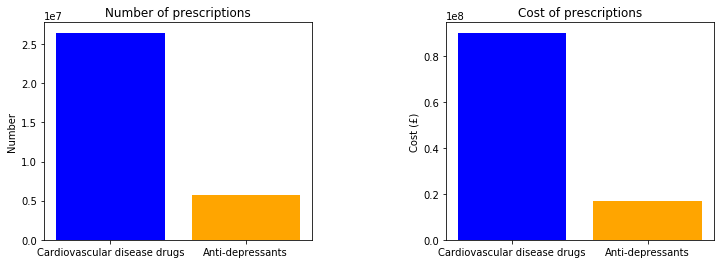

In [822]:
#Plot this information to show it visually
fig = plt.figure(figsize=(12,4))
plt1 = fig.add_subplot(121)
plt2 = fig.add_subplot(122)

# plotting points on each subplot
plt1.bar(prescriptions.index, prescriptions['num_prescriptions'],color=['blue','orange'])
plt1.set_title('Number of prescriptions')
plt1.set_ylabel('Number')
 
plt2.bar(prescriptions.index, prescriptions['cost'],color=['blue','orange'])
plt2.set_title('Cost of prescriptions')
plt2.set_ylabel('Cost (£)')

# adjusting space between subplots
fig.subplots_adjust(hspace=.5,wspace=0.5)

plt.show()
plt.close()

## Question 4
I will now look at total spending and the relatives cost per patient across all practices in England.  First I will create a data frame with the total actual cost and number of registered patients per practice, then I will plot the information in a scatter plot.

In [723]:
# Create database of practices and total act_cost
practice_prescribing_df = prescribing_df[['practice_code','act_cost']].groupby('practice_code').sum().reset_index()
#Add column of number of patients
practice_prescribing_df = pd.merge(practice_prescribing_df, registrations_df[['practice_code','number_of_patients']],\
                                   on='practice_code')
practice_prescribing_df.head()

,practice_code,act_cost,number_of_patients
0,A81001,52194.63,4086
1,A81002,268607.26,19906
2,A81004,139115.40,10165
3,A81005,102914.06,8016
4,A81006,183226.79,14497


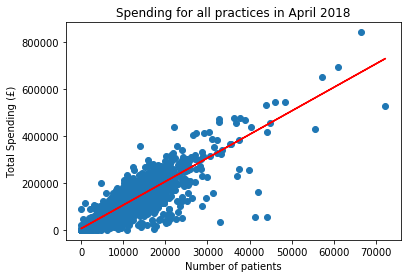

In [726]:
#Set x and y values
x = practice_prescribing_df['number_of_patients']
y = practice_prescribing_df['act_cost']
#create a plot
plt.scatter(x,y)
#label the plot
plt.title('Spending for all practices in April 2018')
plt.xlabel('Number of patients')
plt.ylabel('Total Spending (£)')
#add a trend line
fit = np.polyfit(x, y, deg=1)
plt.plot(x, fit[0] * x + fit[1], color='red')
plt.show()

There is a positive association between number of patients and total spending at a GP practice.  Most practices have less than 300,000 people and spend less than £400,000/month.  There is considerable spread of practices around the trend line.  Next I will calculate the relative spending (ie. spending per patient) and plot this.

In [730]:
#Calculate relative spending
practice_prescribing_df['relative_spending']= practice_prescribing_df['act_cost']/\
practice_prescribing_df['number_of_patients']

#Look at some secriptive stats
practice_prescribing_df.describe()

,act_cost,number_of_patients,relative_spending
count,7191.000000,7191.000000,7191.000000
mean,87842.769907,8207.557224,11.606497
std,59133.286587,5161.846053,38.868946
min,3.250000,3.000000,0.001724
25%,45118.630000,4557.000000,8.875578
50%,76206.840000,7278.000000,10.914659
75%,117871.110000,10742.500000,12.690038
max,842838.180000,72227.000000,2830.020000


There are some extreme outliers which will distort the data, so I have decided to remove the top and bottom 0.05% of GP practices for spending per patients, leaving practices with £1 - £21/patient

In [762]:
#remove outliers
min_x = math.floor(practice_prescribing_df['relative_spending'].quantile(.005))
max_x = math.floor(practice_prescribing_df['relative_spending'].quantile(.995))
practice_prescribing_limited = practice_prescribing_df[practice_prescribing_df['relative_spending'].between(min_x,max_x)]
min_x,max_x

(1, 21)

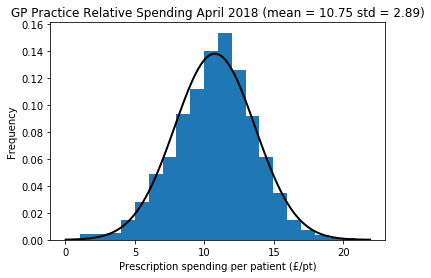

In [770]:
# Use the data without extreme outliers
data = practice_prescribing_limited['relative_spending']

# Calculate mean and standard deviation for the data
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=20, density=True)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("GP Practice Relative Spending April 2018 (mean = %.2f std = %.2f)" % (mu, std))
plt.xlabel("Prescription spending per patient (£/pt)")
plt.ylabel("Frequency")

plt.show()

Spending per patients is normally distributed amongst GP Practices.  In order to target efforts to make efficiency savings, GP practices who have both high total expenditure and high spending per patient can be identified.